# Transformer FEMCA Demonstration
The purpose of this script it to demonstrate the impact of using a new consequence model for the Zone Sub Transfomer FEMCA

Requestors: danielle.fisher@essentialenergy.com.au; ken.holder@essentialenergy.com.au

Author: gavin.treseder@essentialenergy.com.au

# Step 1 - Load the packages
Load python packages to aid with data analysis and visualisation


In [10]:
import numpy as np 
import pandas as pd
import math

from scipy.integrate import quad
import scipy.stats as ss
from matplotlib import pyplot as plt

import tkinter as tk
from tkinter.filedialog import askopenfilename

## Step 2 - Load the data
Load the data from the "Tx FMECA to consequence" file into a dataframe and check the contents are as expected

In [2]:
try:
    file_name
except:
    file_name = askopenfilename(initialdir=os.getcwd())

In [3]:
# Read the file in and remove the first row
df_fmeca = pd.read_excel(file_name, header = 1)

df_fmeca.head()

,TMC code,Category,Equipment,TMC,Band,Function,Functional Failure,Failure Cause,No.,Local Effect,...,Optimal Interval,Protective systems,Protective Population,Protective MTBF,Protective Repair,Protective Failures,Asset Consequence Model,Level Consequence Model,Notes,Unnamed: 54
0,TX 01 01 01,ZS Power Transformer,Zone and Subtrans. Generic Transformers.,TX010101 Zone and Subtrans. Generic Transformers.,Essential Energy,02) Provides insulation of live equipment.,a) Does not provide insulation of live equipment.,EXTERNAL BUSHING damaged porcelain due to flas...,2,"Flashover,",...,0.0,1,0.0,0,0,0.0,Bushing,Major,NaN,NaN
1,TX 01 01 01,ZS Power Transformer,Zone and Subtrans. Generic Transformers.,TX010101 Zone and Subtrans. Generic Transformers.,Essential Energy,02) Provides insulation of live equipment.,a) Does not provide insulation of live equipment.,EXTERNAL BUSHING damaged porcelain due to vand...,3,"Flashover,",...,0.0,1,0.0,0,0,0.0,Bushing,Major,NaN,NaN
2,TX 01 01 01,ZS Power Transformer,Zone and Subtrans. Generic Transformers.,TX010101 Zone and Subtrans. Generic Transformers.,Essential Energy,01) Transformation of power from primary to se...,a) Does not transform power from primary to se...,BUSHINGS faulty connection due to corrosion / ...,4,Overheated Connection,...,631.0,1,0.0,0,0,0.0,NaN,NaN,hot joint bushing,NaN
3,TX 01 01 01,ZS Power Transformer,Zone and Subtrans. Generic Transformers.,TX010101 Zone and Subtrans. Generic Transformers.,Essential Energy,02) Provides insulation of live equipment.,a) Does not provide insulation of live equipment.,EXTERNAL BUSHING internal fault due to oil los...,5,"Flashover, possible secondary damage and flyin...",...,0.0,1,0.0,0,0,0.0,Bushing,Major,NaN,NaN
4,TX 01 01 01,ZS Power Transformer,Zone and Subtrans. Generic Transformers.,TX010101 Zone and Subtrans. Generic Transformers.,Essential Energy,02) Provides insulation of live equipment.,a) Does not provide insulation of live equipment.,EXTERNAL BUSHING low resistance due to surface...,6,"Flashover, possible secondary damage and flyin...",...,0.0,1,0.0,0,0,0.0,Bushing,Major,NaN,NaN


In [4]:
filter_cols = ['Failure Cause', 'Proposed Task', 'Test', 'Scheduled Task', 'Scheduled Interval', 'Asset Consequence Model', "Level Consequence Model"]

df_tasks = df_fmeca[filter_cols]
df_tasks.head()

,Failure Cause,Proposed Task,Test,Scheduled Task,Scheduled Interval,Asset Consequence Model,Level Consequence Model
0,EXTERNAL BUSHING damaged porcelain due to flas...,Examine all transformer bushing surfaces for d...,NaN,Examine all transformer bushing surfaces for d...,ZS Inspect,Bushing,Major
1,EXTERNAL BUSHING damaged porcelain due to vand...,Examine all transformer bushing surfaces for d...,NaN,Examine all transformer bushing surfaces for d...,ZS Inspect,Bushing,Major
2,BUSHINGS faulty connection due to corrosion / ...,Examine bushing connection condition on load u...,NaN,Examine bushing connection condition on load u...,Infrared Scan,NaN,NaN
3,EXTERNAL BUSHING internal fault due to oil los...,Check bushing sight glass for correct oil level.,NaN,Check bushing sight glass for correct oil level.,ZS Inspect,Bushing,Major
4,EXTERNAL BUSHING low resistance due to surface...,Examine transformer bushing surface for contam...,NaN,Examine transformer bushing surface for contam...,6yr Maint.,Bushing,Major


In [6]:
filter_cols = ["Operation Loss:","CF Interval", "MTBF", "Examination Time (m):", "Exam Success", "Setup Cost", "Exam Cost", "Planned Repair Cost", "Call Out, Secondary Damage", 	"Unplanned Failure Cost"]

df_params = df_fmeca[filter_cols]
df_params.head()

,Operation Loss:,CF Interval,MTBF,Examination Time (m):,Exam Success,Setup Cost,Exam Cost,Planned Repair Cost,"Call Out, Secondary Damage",Unplanned Failure Cost
0,0,0,169567,0,0.0,0.0,0.0,0,0,0
1,0,0,1196389,0,0.0,0.0,0.0,0,0,0
2,120000,1460,34067,10,95.0,15.0,0.0,2500,142500,20000
3,0,0,0,0,0.0,0.0,0.0,0,0,0
4,12000,0,0,0,NaN,NaN,0.0,0,12000,0


## Estimate the optimum interval

Using the same method from MMIR

In [7]:
def optimum_interval(operation_loss, cf_interval, mtbf, exam_time, exam_success, setup_cost, exam_cost, planned_repair_cost, call_out, unplanned_failure_cost):
    
    # Scale some of the units
    inspect_success = exam_success / 100

    inspect_cost = exam_cost + setup_cost # Inpsection Cost
    penalty = operation_loss + call_out # Penalty
    T = cf_interval

    optimum = math.log(((-mtbf / T) * inspect_cost) / (penalty * math.log(1 - inspect_success))) / math.log(1 - inspect_success)

    optimum_interval = T / optimum

    return optimum_interval

In [13]:
def optimum_interval_wrapper(row):
    try:
        return optimum_interval(*row)
    except:
        return "error"

In [8]:
optimum_interval(*tuple(df_params.iloc[8]))

1852.2650777102656

In [9]:
dict(df_params.iloc[8])

{'Operation Loss:': 120000.0,
 'CF Interval': 3650.0,
 'MTBF': 41948.0,
 'Examination Time (m):': 15.0,
 'Exam Success': 98.0,
 'Setup Cost': 55.0,
 'Exam Cost': 110.0,
 'Planned Repair Cost': 40000.0,
 'Call Out, Secondary Damage': 960000.0,
 'Unplanned Failure Cost': 800000.0}

In [17]:
df_results = pd.DataFrame(df_fmeca['Optimal Interval'])
df_results['new'] = df_params.apply(optimum_interval_wrapper, axis=1)

In [18]:
df_results

,Optimal Interval,new
0,0.0,error
1,0.0,error
2,631.0,566.752
3,0.0,error
4,0.0,error
...,...,...
105,0.0,error
106,3325.0,error
107,538.0,1436.38
108,3325.0,error


In [22]:
df_results.loc[df_results['new']!='error']

,Optimal Interval,new
2,631.000000,566.752
7,538.000000,1436.38
8,268.000000,1852.27
11,-5076.364746,-1455.04
13,0.000000,259.302
14,2049.000000,1725.23
15,0.000000,1644.87
18,0.000000,29946.6
22,0.000000,4977.46
25,1825.235229,2049.68


In [175]:
alpha = 100
beta = 1.5
gamma = 0

n_tx = 100
test_age = 50
bushing = {}

for i in range(3):
    bushing[i] = ss.weibull_min.rvs(beta, scale=alpha, loc=gamma, size=n_tx)

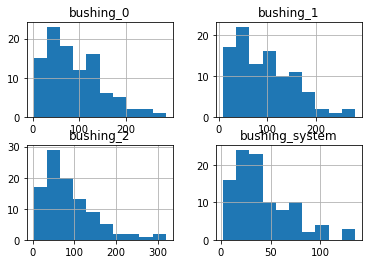

In [181]:
df_failures = pd.DataFrame(bushing).add_prefix('bushing_')
df_failures['bushing_system'] = df_failures.min(axis=1)
df_failures.hist();

In [182]:
wbl = {}

for b in list(df_failures):
    wbl[b] = ss.weibull_min.fit(df_failures[b], floc=0)
wbl

{'bushing_0': (1.5378205712839965, 0, 99.13194559785781),
 'bushing_1': (1.5734207643806268, 0, 105.01082448150137),
 'bushing_2': (1.3644538794697592, 0, 94.65897551692697),
 'bushing_system': (1.467477842313944, 0, 46.60368942248521)}

In [178]:
t = np.linspace(0,100,101)

wbl_curves = {}

for b in list(df_failures):
    wbl_curves[b + '_sf'] = ss.weibull_min.sf(t, wbl[b][0], scale=wbl[b][2], loc=wbl[b][1])

<AxesSubplot:>

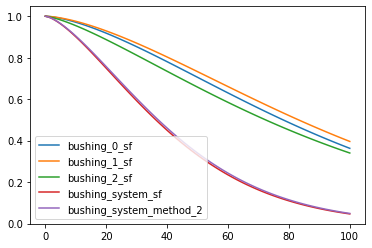

In [179]:
df = pd.DataFrame(wbl_curves)
df['bushing_system_method_2'] = df[['bushing_0_sf', 'bushing_1_sf', 'bushing_2_sf']].product(axis=1)
df.plot()